In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

In [14]:
# %matplotlib
# %matplotlib

In [15]:
dossier_mad_stat = '2.MAD Statique/'
labels = np.genfromtxt(dossier_mad_stat + f'/data_MS_90anches.txt', delimiter='', dtype=str)[0,:]
labels = np.delete(labels, 2) # data sans k
# print(labels)
data = np.genfromtxt(dossier_mad_stat + f'/data_MS_90anches.txt', delimiter='', skip_header=1)
force = data[:,1]
data = data[:,2:]

S00 = data[0]
F_max = data[1]
k = data[2]
Coude = data[3]
Fuite = data[4]

data = np.delete(data, 2, axis=1) # data sans k
print(data)
# print(X)

[[15.95192006  5.43411591  2.51742737  1.46100645]
 [14.50126903  5.39903831  2.40025509  1.68430646]
 [13.63115676  5.42559219  2.51491124  1.48123727]
 [15.31005764  5.80552587  2.56688959  1.58338451]
 [13.95245784  5.42526954  2.26003924  1.42634867]
 [13.49010345  5.22457901  2.2172402   1.18564985]
 [14.13113527  5.76362724  2.68099994  1.67689306]
 [14.15662869  5.54367925  2.67436304  1.52869472]
 [13.28390262  5.47890916  2.47848546  1.02824752]
 [13.04894375  5.50801108  2.15737891  1.27506603]
 [14.79122147  5.65303381  2.40218395  1.10801169]
 [14.5040994   5.63586607  2.53435404  1.43328138]
 [14.26137253  5.30113328  2.1925805   1.12924779]
 [13.35641054  5.71100376  2.3645001   1.10478912]
 [14.571001    5.19953642  2.53219383  1.53962988]
 [13.64805788  5.45651243  1.94187527  1.44767919]
 [14.62112455  5.49783743  2.27359885  1.45907114]
 [15.03502084  5.31155458  2.57708819  1.60215946]
 [15.16433481  5.30923389  2.28966759  1.45500486]
 [14.67217978  5.35255315  2.33

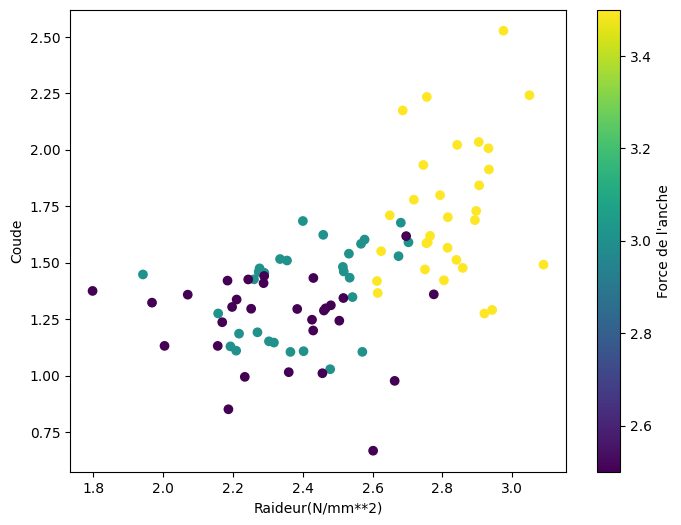

In [16]:
# Scatter 

x = 2
y = 3

plt.close('all')
plt.figure(num='Scatter', figsize=(8,6))
plt.scatter(data[:,x], data[:,y], c=force, cmap='viridis')
plt.xlabel(f'{labels[x+1]}')
plt.ylabel(f'{labels[y+1]}')
plt.colorbar(location='right', label='Force de l\'anche')

[(0.267004, 0.004874, 0.329415, 1.0), (0.127568, 0.566949, 0.550556, 1.0), (0.974417, 0.90359, 0.130215, 1.0)]


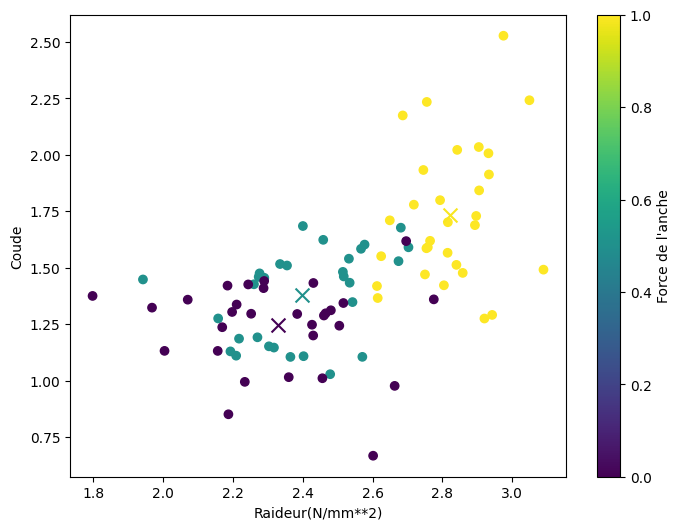

In [38]:
# Barycentre

def barycentre_sans_masses(x, y):
    x_total = sum(x)  # Somme des x
    y_total = sum(y)  # Somme des y
    n = len(x)  # Nombre de points
    barycentre = (x_total / n, y_total / n)
    return barycentre

# Scatter 
x = 2
y = 3

plt.close('all')
plt.figure(num='Scatter', figsize=(8,6))

barycentres = []
for i in (2.5, 3, 3.5):
    indices = np.where(np.isin(force, i))[0]
    data_bary = data[indices]
    # print(data_bary)
    barycentre = barycentre_sans_masses(data_bary[:,x], data_bary[:,y])
    barycentres.append(barycentre)
# print(barycentres)


plt.scatter(data[:,x], data[:,y], c=force, cmap='viridis')
colors = [plt.get_cmap('viridis')(i) for i in [0, 0.5, 0.99]]
print(colors)
[plt.scatter(barycentre[0], barycentre[1], color=colors[indx], marker='x', s=100) for indx, barycentre in enumerate (barycentres)]
plt.xlabel(f'{labels[x+1]}')
plt.ylabel(f'{labels[y+1]}')
plt.colorbar(location='right', label='Force de l\'anche')

In [18]:
import scipy.stats as stats

# Test d'hypothèse


for i in (2.5, 3, 3.5) : # traitement des données par rapport à la force définie par le constructeur
    data_hypo = data[np.where(np.isin(force, i))[0]]
    data_moy = np.mean(data_hypo, axis=0) # moyennes par colonne
    data_var = np.var(data_hypo, axis=0) # matrice des variances par colonne
    # print(data_moy, data_var)


# OULALALA
data_25 = data[np.where(np.isin(force, 2.5))[0]]
data_3 = data[np.where(np.isin(force, 3))[0]]
data_35 = data[np.where(np.isin(force, 3.5))[0]]
f_stat, p_value = stats.f_oneway(*data_25, *data_3, *data_35)
print(f_stat)

# H0 : hypothèse null = valeur de la force constructeur 
# H1 : hypothèse alternatif = 
# on fait la différence entre deux moyennes sur une des caractéristique => cette valeur c'est l'hypothèse nulle H0



(30, 4)
(30, 4)
(30, 4)
0.016412434708315018


In [7]:
# # linear regression

# feature = 1
# target = 0

# x_train, x_test, y_train, y_test = train_test_split(data[:,feature].reshape(-1, 1), data[:,target], test_size=0.2, random_state=42)
# linear_reg_model = LinearRegression()
# linear_reg_model.fit(x_train, y_train)
# y_pred = linear_reg_model.predict(x_test)
# mse = mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# x_range = np.linspace(min(data[:,feature]), max(data[:,feature]), 100).reshape(-1, 1)  # Plage de valeurs pour la ligne
# y_range_pred = linear_reg_model.predict(x_range)  # Prédictions pour ces valeurs

# plt.close('all')
# plt.figure(num='linear regression', figsize=(8,6))
# plt.scatter(data[:,feature], data[:,target], c=data[:,0], cmap='viridis')
# plt.plot(x_range, y_range_pred, color='red', label='Ligne de régression')
# plt.xlabel(f'{labels[x+1]}')
# plt.ylabel(f'{labels[y+1]}')
# plt.colorbar(location='right', label='Force de l\'anche')
# plt.title('Régression Linéaire')
# plt.legend()

# # Afficher le graphique
# plt.show()

[[13.5905728   5.66653427  2.30535332  1.21168081]
 [15.41135963  6.22629532  2.7729037   1.78090856]
 [14.63526906  5.48088257  2.50613645  1.41238016]]


31.77263324114852

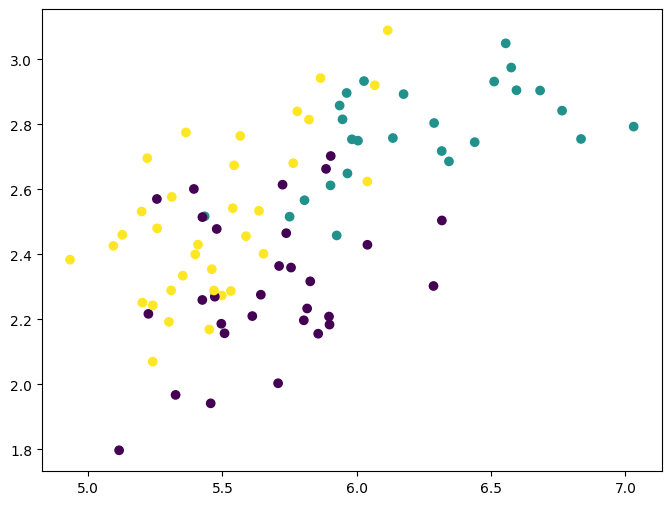

In [8]:
# Clustering

x=1
y=2

model = KMeans(n_clusters=3)    #, n_init=10, max_iter=300)
model.fit(data)
# model.labels_
model.predict(data)
model.cluster_centers_ 
print(model.cluster_centers_)
plt.close('all')
plt.figure(num='CLustering', figsize=(8,6))
plt.scatter(data[:,x], data[:,y], c=model.predict(data))
# plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c="r")
model.inertia_ # fonction de coût

[[-0.91158693 -0.24051438 -0.19617667 -0.26958637]
 [-0.35824843  0.85475762  0.29172807  0.23652104]]
[0.75161564 0.18124671]


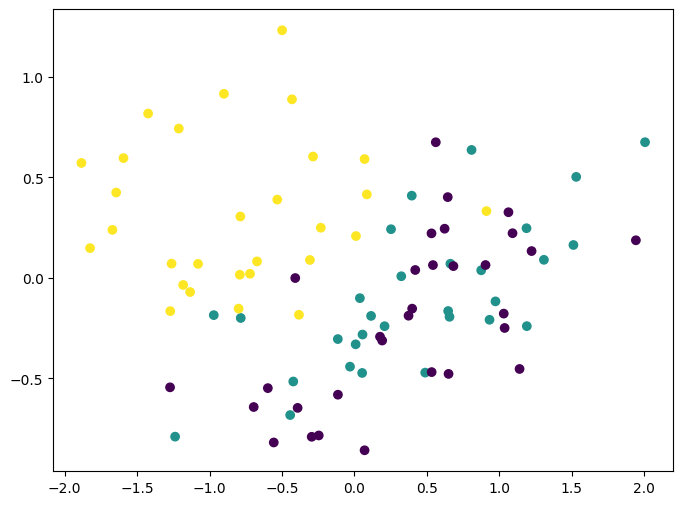

In [9]:
# PCA - réduction de dimensions

scaler = StandardScaler()
X_centered_reduced = scaler.fit_transform(data) # centrer et réduire les données du set

model_PCA = PCA(n_components=2)
X_reduced = model_PCA.fit_transform(data)

plt.close('all')
plt.figure(num='PCA', figsize=(8,6))
# plt.scatter(X_reduced[:,0], X_reduced[:,1])
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=force, cmap='viridis')

print(model_PCA.components_)
print(model_PCA.explained_variance_ratio_)

# pour savoir quelle dimension donner à notre modèle, on peut étudier l'évolution de la variance. Il ne faut pas une vairance inférieure à 95%-99%
# plt.plot(np.cumsum(model_PCA.explained_variance_ratio_))

## Matrices de Correlation, Covariance, Similarité
[Correlation](https://numpy.org/doc/2.0/reference/generated/numpy.corrcoef.html) :  
$$
R_{ij} = \frac{C_{ij}}{\sqrt{C_{ii} C_{jj}}}
$$
[Covariance](https://numpy.org/doc/2.0/reference/generated/numpy.cov.html) : 
$$
\text{Cov}(X,Y) = \frac{1}{N} \sum_{i=1}^{N} (X_i - \bar{X})(Y_i - \bar{Y})
$$
[Cosine Similarity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html) : 
$$
K(X, Y) = \frac{\langle X, Y \rangle}{\|X\| \cdot \|Y\|}
$$


In [10]:
data_transpos = data.T
correlation_matrix = np.abs(np.corrcoef(data_transpos))
covariance_matrix = np.cov(data_transpos)
similarity_matrix = cosine_similarity(data)
# similarity_df = pd.DataFrame(similarity_matrix, index=data.index, columns=data.index)



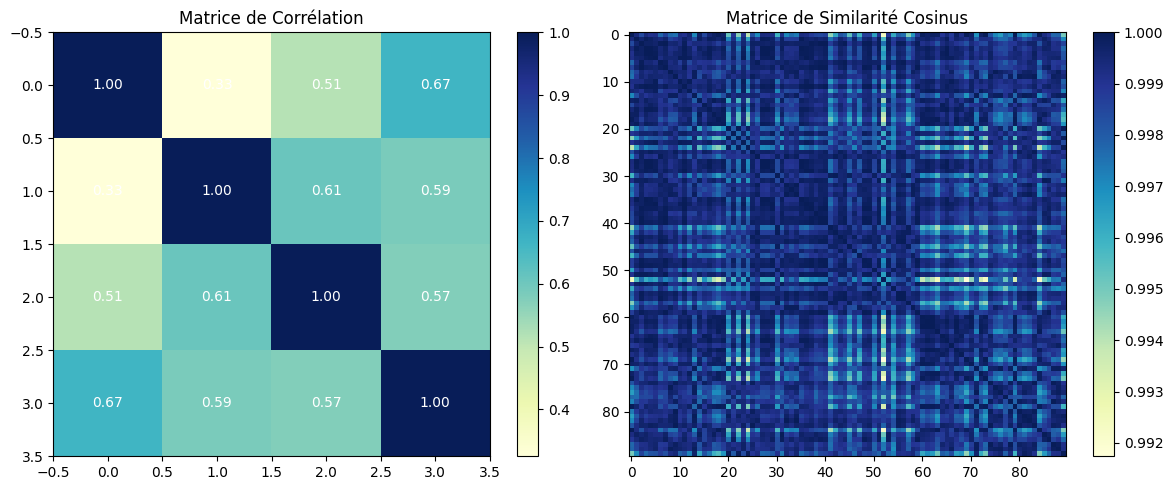

In [11]:
plt.close('all')

# fig, axs = plt.subplots(1, 3, figsize=(14, 4.2))
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

def plot_anotation(matrix, num_axs):
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            axs[num_axs].text(j, i, f'{matrix[i, j]:.2f}', ha='center', va='center', color='white')

# Matrice de corrélation avec imshow
im1 = axs[0].imshow(correlation_matrix, cmap='YlGnBu', aspect='auto')
plot_anotation(correlation_matrix, 0)
axs[0].set_title('Matrice de Corrélation')
fig.colorbar(im1, ax=axs[0])  # Ajouter une barre de couleur pour l'échelle

# # Matrice de covariance avec imshow
# im2 = axs[1].imshow(covariance_matrix, cmap='YlGnBu', aspect='auto')
# plot_anotation(covariance_matrix, 1)
# axs[1].set_title('Matrice de Covariance')
# fig.colorbar(im2, ax=axs[1])  # Ajouter une barre de couleur pour l'échelle

# Matrice de similarité cosinus avec imshow
im3 = axs[1].imshow(similarity_matrix, cmap='YlGnBu', aspect='auto')
# plot_anotation(similarity_matrix, 1)
axs[1].set_title('Matrice de Similarité Cosinus')
fig.colorbar(im3, ax=axs[1])  # Ajouter une barre de couleur pour l'échelle

plt.tight_layout()
plt.show()

In [12]:
# im3 = plt.imshow(np.abs(similarity_matrix), cmap='YlGnBu', aspect='auto')
# # plot_anotation(similarity_matrix, 2)
# plt.title('Matrice de Similarité Cosinus')
# fig.colorbar(im3, ax=axs[2])

## Modèle prédictif de la force constructeur